# Correlation Downstream Analysis

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-09 
Git hash: 6981e4093c2e6b3d7a4e4ca51337c4f0c41a767e


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']

In [3]:
# imports
from itertools import combinations
from numpy.random import choice
from ncbi_remap.parser import parse_featureCounts_counts
from dask import delayed, compute
from dask import dataframe as dd
from dask import multiprocessing
from dask.diagnostics import ProgressBar
from sklearn.neighbors import KernelDensity

In [4]:
# Constatns
PATTERN = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts'
IGNORE = []

In [5]:
# useful functions
def read_data(srx, srr):
    fname = PATTERN.format(srx=srx, srr=srr)
    if os.path.exists(fname):
        return parse_featureCounts_counts(srr, fname).unstack(level=0)
    else:
        return None

## How many SRXs have multiple SRRs?

The table below shows how many SRXs have multiple SRRs. The vast majority of SRXs have a single SRR. Very few SRXs have more than 3 SRRs. 

In [6]:
# Query db
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {'$unwind': '$runs.pre_aln_flags'},
    {
        '$group': {
            '_id': '$_id',
            'srrs': {'$addToSet': '$runs.srr'},
            'pre_aln_flags': {'$addToSet': '$runs.pre_aln_flags'}
        }
    },
    {
        '$match': {
            'pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'num_runs': {'$size': '$srrs'}
        }
    },
]))

df = pd.DataFrame(agg)

In [7]:
# summarize counts of SRRs per SRX
cnts = df.num_runs.value_counts().to_frame()
cnts.index.name = 'Number SRRs'
cnts.columns = ['Count']
cnts.applymap(lambda x: '{:,}'.format(x))

,Count
Number SRRs,
1,"13,456"
2,"1,027"
3,415
5,344
8,222
4,193
6,87
7,61
9,12


## Which SRRs are missing the files?

In [8]:
# Get a list of all complete and check that they have the files.
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
        }
    }
])

all_srr = pd.DataFrame(list(agg))

In [9]:
# Check and see if files are missing. 
def check_file(srx, srr):
    fname = PATTERN.format(srx=srx, srr=srr)
    return srx, srr, os.path.exists(fname)
    dfs.append(delayed(os.path.exists)(fname))
    
dfs = []
for _, row in all_srr.iterrows():
    dfs.append(delayed(check_file)(row.srx, row.srr))

srr_chk_counts = pd.DataFrame(list(compute(*dfs, num_workers=10)), columns=['srx', 'srr', 'flag_counts_exist'])

In [10]:
# There are 10,632 files missing
srr_chk_counts.flag_counts_exist.value_counts().to_frame().applymap(lambda x: '{:,}'.format(x))

,flag_counts_exist
True,"22,189"
False,"10,632"


In [11]:
# IGNORE SRXs with missing files for now.
IGNORE = list(set(srr_chk_counts.loc[~srr_chk_counts.flag_counts_exist, 'srx'].tolist()))
#IGNORE.extend(['SRX1059356', ])

## What is the correlation like when there are 2 SRRs?

### Calculate correlation among SRRs within SRX.

This first approach just calculates SRRs within each SRX (with two SRRs). I then plot the distribution and see that the majority of samples have a correlation ≥.90, with only 65 SRXs with less than that.

The question is where to draw that cutoff. While .90 seems reasonable, perhaps a cutoff at .95 would be better. 

In [12]:
# Grab srx/srr where there are two srr per srx.
srxs = df.loc[df.num_runs == 2, 'srx'].values.tolist()

agg = remap.aggregate([
    {
        '$match': {
            '$and': [
                {'_id': {'$in': srxs}},
                {'_id': {'$nin': IGNORE}},
            ]
        }
    },
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
        }
    }
])

twos = pd.DataFrame(list(agg))

In [13]:
# Create delayed pipeline for reading and calcuating corrs
def calc_corr(srx, srrs):
    curr = []
    for srr in srrs[0]:
        curr.append(read_data(srx, srr))
    merged = pd.concat(curr, axis=1)
    return srx, merged.corr().iloc[0, 1], merged.sum().to_dict()
    
dfs = []
for srx, srrs in twos.groupby('srx').aggregate({'srr': lambda x: x.tolist()}).iterrows():
    dfs.append(delayed(calc_corr)(srx, srrs))

In [14]:
# do all the computation
pair_srr_corr = compute(*dfs, num_workers=10)

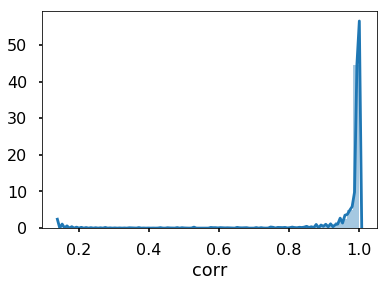

In [15]:
# Make table and plot results
df_corr = pd.DataFrame(list(pair_srr_corr), columns=['srx', 'corr', 'srr_counts'])
sns.distplot(df_corr['corr'])

In [16]:
# print summary numbers
print('Total: {:,}'.format(df_corr.shape[0]))
print("""\
<0.9: {}
<.95: {}
<.98: {}
""".format((df_corr['corr'] < .90).sum(), (df_corr['corr'] < .95).sum(), (df_corr['corr'] < .98).sum()))

Total: 1,025
<0.9: 65
<.95: 121
<.98: 223



### Let's Bootstrap

In [17]:
# Create delayed pipeline for reading and calcuating corrs
def get_data(srx, srr):
    val = read_data(srx, srr)
    if val is None:
        print(srx, srr)
    else:
        return val
    
dfs = []
for srx, srrs in twos.groupby('srx').aggregate({'srr': lambda x: x.tolist()}).iterrows():
    for srr in srrs[0]:
        dfs.append(delayed(get_data)(srx, srr))

# Build dataframe
df_counts = dfs[0].compute()
df_counts = df_counts.join(list(compute(*dfs[1:], num_workers=10)))

# Calculate pairwise correlation
all_corr = df_counts.corr()

In [18]:
# Use a bootstrap type method to identify where the 95% cutoff for correlations should be.
def kde(data, corr_df, alpha=0.95):
    """Calculates KDE and then estimates correlation which 95% of samples are below.
    
    Parameters:
    -----------
    data: np.array
        Array of tuples with pairs of SRRs. The pairs of SRRs should be randomly put together.
    
    corr_df: pandas.DataFrame
        All pairwise correlations among all SRRs being examined.
        
    alpha: float < 1
        The cutoff to use to estimate correlation value that is larger than `alpha` * 100 samples.
    """
    # Pull out correlations
    corrs = []
    for first, second in data:
        corrs.append(corr_df.loc[first, second])

    # Fit emperical KDE
    kde_skl = KernelDensity(bandwidth=0.2)
    kde_skl.fit(np.asarray(corrs)[:, np.newaxis])
    
    # Calculate pdf on Grid
    x_grid = np.linspace(-1, 2, 1000)
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    # Integrate and find cutoff at alpha
    cum = np.cumsum(np.exp(log_pdf)) 
    return x_grid[np.argmax((cum / max(cum)) > alpha)]

# Figure out all possible combinations
all_possible_combos = np.array(list(combinations(twos.srr.tolist(), 2)))
idx = np.arange(0, len(all_possible_combos))

# Lets do some experiments
nexp = 1000                   # number of experiments to run
nobs = df_corr.shape[0]        # number of samples per experiment
experiments = all_possible_combos[choice(idx, size=(nexp, nobs)), :]

In [34]:
# Compute kde and cutoff loctions
random = [delayed(kde)(x, all_corr) for x in experiments[:900]]
with ProgressBar():
    random = compute(*random, num_workers=10, get=multiprocessing.get)

[################################        ] | 81% Completed |  4min 59.1s

Process ForkPoolWorker-79:
Process ForkPoolWorker-86:
Process ForkPoolWorker-87:
Process ForkPoolWorker-85:
Process ForkPoolWorker-84:
Process ForkPoolWorker-81:
Process ForkPoolWorker-78:
Process ForkPoolWorker-88:
Process ForkPoolWorker-83:
Process ForkPoolWorker-82:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/fearjm/miniconda3/envs/ncbi_remap/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/data/fearjm/miniconda3/envs/ncbi_remap/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/fearjm/miniconda3/envs/ncbi_remap/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    s

[################################        ] | 81% Completed |  4min 59.2s


KeyboardInterrupt: 

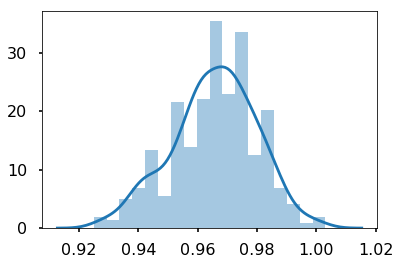

In [25]:
sns.distplot(list(random))

In [32]:
experiments[:1000].shape

(1000, 1025, 2)